![](images/mlp.PNG)

# **1. Deep Learning basics with Pytorch**


# Kaggle- Multilayered Perceptron (MLP) implemention on MNIST dataset
Let us now load the dataset from Kaggle repo and train our model

In [26]:
import os
from pathlib import Path
import torch
from torch.utils.data import TensorDataset ,DataLoader
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
PATH=Path("../input")
print(os.listdir("../input"))

['train.csv', 'test.csv', 'sample_submission.csv']


## Load Data 

In [28]:
train=pd.read_csv(PATH/'train.csv')
test=pd.read_csv(PATH/'test.csv')
train.shape,test.shape

((42000, 785), (28000, 784))

8


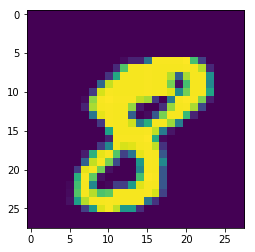

In [30]:
# Vizuvalizing the data set

import matplotlib.pyplot as plt
import numpy
def imshow(image, ax=None, title=None, normalize=True):

    if ax is None:
        fig, ax = plt.subplots()
        
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

plt.imshow(numpy.array(train.iloc[10,1:]).reshape(28,28))
print(train.iloc[10,0])


## Extracting Input and Target Variable

In [31]:
x=train.drop("label",axis=1)
y=np.array(train['label'])
x.shape,y.shape

((42000, 784), (42000,))

In [39]:
torch.from_numpy(x.values[1]).shape

torch.Size([784])

## Train -Test Split -Pytorch

In [48]:
torch_X_train = torch.from_numpy(x.values).type(torch.FloatTensor)/255
torch_y_train = torch.from_numpy(y).type(torch.LongTensor)
myDataset = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
valid_no  = int(0.2 * len(myDataset))

# so divide the data into trainset (80 %) and testset (20 %)
trainSet,testSet = torch.utils.data.random_split(myDataset,(len(myDataset)-valid_no,valid_no))
print(f"len of trainSet {len(trainSet)} , len of testSet {len(testSet)}")
batch_size=80
train_loader  = DataLoader(trainSet , batch_size=batch_size ,shuffle=True) 
test_loader  = DataLoader(testSet , batch_size=batch_size ,shuffle=True)

print(f"len of train_loader {len(train_loader)} , len of test_loader {len(test_loader)}")


len of trainSet 33600 , len of testSet 8400
len of train_loader 420 , len of test_loader 105


## Network

In [79]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
        
model=Network()
#optimizer=optim.Adam(model.parameters(),lr=0.01)
#optimizer=optim.SGD(model.parameters(), lr=0.04, weight_decay= 1e-7, momentum = 0.9,nesterov = True)
optimizer=torch.optim.Adamax(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)


criterion=nn.CrossEntropyLoss()

## Train 

In [81]:
epochs=15
train_losses,test_losses=[],[]
for e in range(epochs):
    running_loss=0
    for images,labels in train_loader:
        optimizer.zero_grad()
        log_ps=model(images)
        loss=criterion(log_ps,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    else:
        test_loss=0
        accuracy=0
        
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps=torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))    

Epoch: 1/15..  Training Loss: 0.040..  Test Loss: 0.085..  Test Accuracy: 0.975
Epoch: 2/15..  Training Loss: 0.036..  Test Loss: 0.086..  Test Accuracy: 0.974
Epoch: 3/15..  Training Loss: 0.030..  Test Loss: 0.086..  Test Accuracy: 0.975
Epoch: 4/15..  Training Loss: 0.027..  Test Loss: 0.088..  Test Accuracy: 0.976
Epoch: 5/15..  Training Loss: 0.023..  Test Loss: 0.086..  Test Accuracy: 0.978
Epoch: 6/15..  Training Loss: 0.022..  Test Loss: 0.085..  Test Accuracy: 0.978
Epoch: 7/15..  Training Loss: 0.018..  Test Loss: 0.085..  Test Accuracy: 0.978
Epoch: 8/15..  Training Loss: 0.018..  Test Loss: 0.084..  Test Accuracy: 0.979
Epoch: 9/15..  Training Loss: 0.016..  Test Loss: 0.089..  Test Accuracy: 0.976
Epoch: 10/15..  Training Loss: 0.014..  Test Loss: 0.087..  Test Accuracy: 0.979
Epoch: 11/15..  Training Loss: 0.012..  Test Loss: 0.093..  Test Accuracy: 0.979
Epoch: 12/15..  Training Loss: 0.012..  Test Loss: 0.089..  Test Accuracy: 0.978
Epoch: 13/15..  Training Loss: 0.011.

## Save our model

In [58]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 Network(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [60]:
torch.save(model.state_dict(), 'checkpoint.pth')

## Load our model

In [61]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [62]:
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [63]:
checkpoint = {'input_size': 784,
              'output_size': 10,
              'hidden_layers': [256,128,64],
              'state_dict': model.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

## Load Test Data

In [64]:
test_images = pd.read_csv("../input/test.csv")
test_image = test_images.loc[:,test_images.columns != "label"].values
test_dataset = torch.from_numpy(test_image).type(torch.FloatTensor)/255
print(test_dataset.shape)
#test_dataset = torch.utils.data.TensorDataset(test_dataset)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False)

torch.Size([28000, 784])


In [65]:
results = []
with torch.no_grad():
    model.eval()
    for images in new_test_loader:
        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim = 1)
        results += top_class.numpy().tolist()

## Check the results

In [66]:
predictions = np.array(results).flatten()
print(predictions[:5])
print(predictions.shape)

[2 0 9 9 3]
(28000,)


## Submit for Scoring

In [67]:
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("my_submissions.csv", index=False, header=True)

# Reference 

[Introduction to Pytorch-Udacity](https://github.com/udacity/deep-learning-v2-pytorch/tree/master/intro-to-pytorch)